In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pymc3 as pm
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import theano.tensor as tt

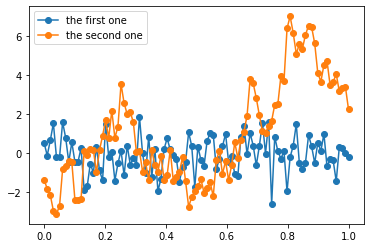

In [2]:
np.random.seed(42) #finally
x = np.linspace(0, 1, 100)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label = 'the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label = 'the second one')

plt.legend()
plt.plot();

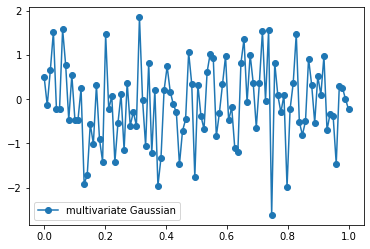

In [3]:
np.random.seed(42) #finally
x = np.linspace(0, 1, 100)

y = np.random.multivariate_normal(np.zeros_like(x), np.eye(len(x)))
plt.plot(x, y, 'o-', label = 'multivariate Gaussian')

plt.legend()
plt.plot();

We need a multivariate Gaussian with the right covariance structure.
To get these we use functions known as **kernels**.
For our purposes they take inputs and output a number that specifies the similarity of points. 
Exponential quadratic kernel is popular.

In [4]:
def exp_quad_kernel(x, knots, l = 1): 
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*l**2)) for k in knots])

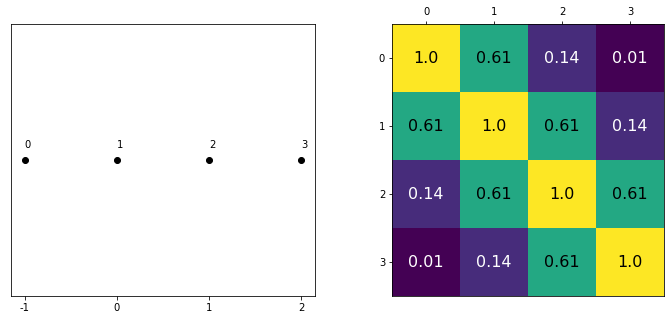

In [6]:
data = np.array([-1, 0, 1, 2])
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                  color = colors[int(im.norm(cov[i, j]) > 0.5)],
                  ha = 'center', va = 'center', fontdict = {'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

In [8]:
from scipy import stats

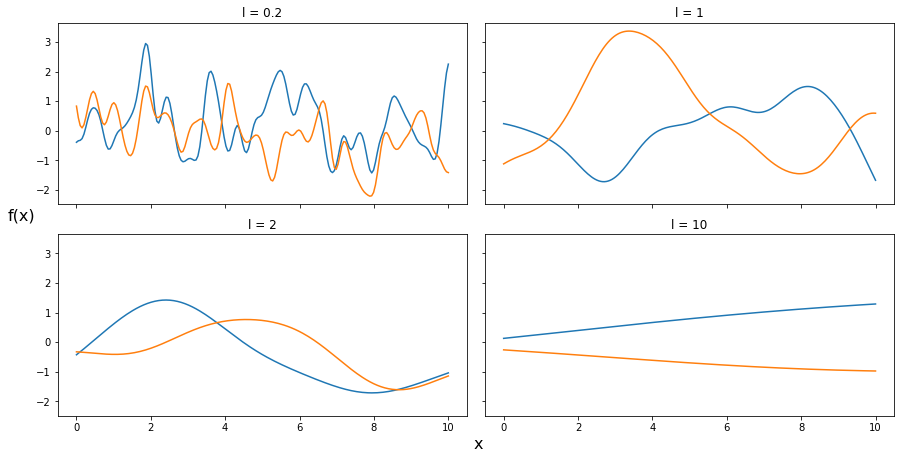

In [10]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize = (12, 6), 
                      sharex = True, sharey = True, 
                      constrained_layout = True)
ax = np.ravel(ax)
for idx, l in enumerate((0.2, 1, 2, 10)): 
    cov = exp_quad_kernel(test_points, test_points, l)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov = cov,
                                                           size = 2).T)
    ax[idx].set_title(f'l = {l}')

fig.text(0.51, -0.03, 'x', fontsize = 16)
fig.text(-0.03, 0.5, 'f(x)', fontsize = 16)
plt.plot();

Yeah, so the "l"-norm (as I suppose it is) controls regularization it seems.

# Gaussian processes (regression)

Text(0, 0.5, 'f(x)')

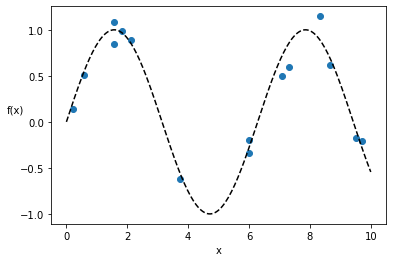

In [11]:
np.random.seed(42) # "random"
x = np.random.uniform(0, 10, size = 15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation = 0)

Recall that marginal likelihood is integral of likelihood & prior.

In [46]:
# one-dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for length scale kernel parameter
    l = pm.Gamma('l', 2, 0.5)
    
    # instantiate covariance function
    cov = pm.gp.cov.ExpQuad(1, ls = l)
    
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func = cov)
    
    # prior 
    ϵ = pm.HalfNormal('ϵ', 25)
    
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X = X, y = y, noise = ϵ)

In [47]:
with model_reg:
    
    trace = pm.sample(1000)
    post = pm.sample_posterior_predictive(trace, samples = 50)
    prior = pm.sample_prior_predictive(samples = 50)
    
    md = {'model': model_reg, 
         'trace': trace,
         'prior': prior,
         'post': post}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, l]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7159999382092647, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


array([[<AxesSubplot:title={'center':'l'}>,
        <AxesSubplot:title={'center':'l'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

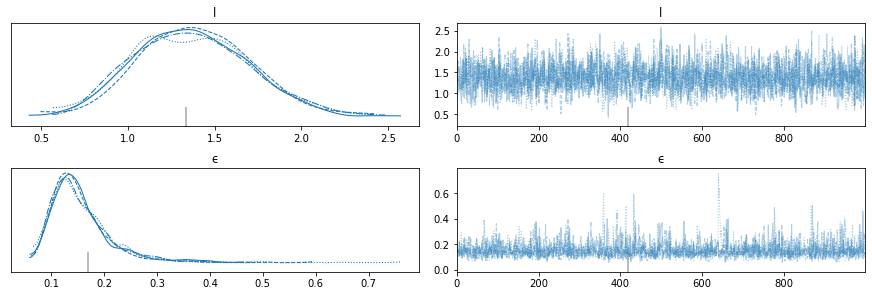

In [48]:
az.plot_trace(md.get('trace'))

In [49]:
# conditional distribution evaluated over new input locations
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:, None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [50]:
# now works
with model_reg:
    pred_samples = pm.sample_posterior_predictive(md.get('trace'), 
                                                 var_names = ["f_pred"], 
                                                 samples = 82)

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


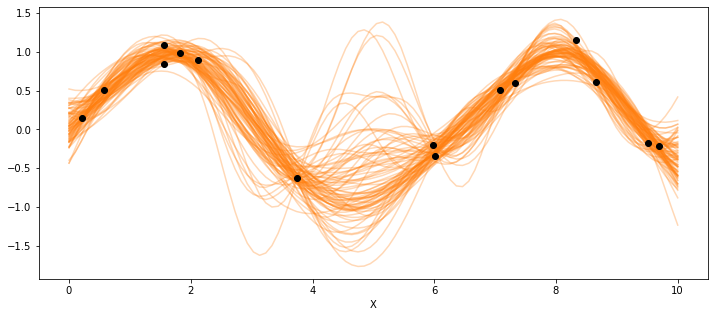

In [51]:
# cool plot
_, ax = plt.subplots(figsize = (12, 5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha = 0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.plot();

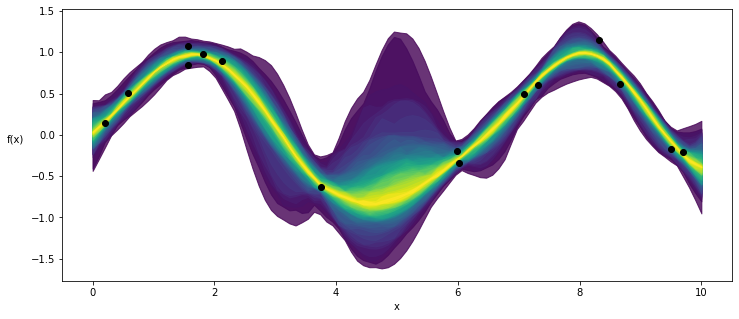

In [52]:
# cool plot 2
# our model is a bit more fucked..
_, ax = plt.subplots(figsize = (12, 5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, 
                       palette = 'viridis', plot_samples = False)

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation = 0, labelpad = 15)
plt.plot();

Text(0.5, 0, 'X')

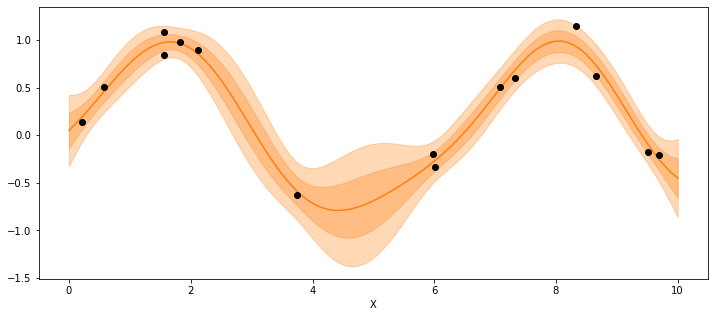

In [53]:
_, ax = plt.subplots(figsize = (12, 5))

point = {'l': md.get('trace')['l'].mean(), 'ϵ': md.get('trace')['ϵ'].mean()}
mu, var = gp.predict(X_new, point = point, diag = True)
sd = var**0.5

ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
               mu - sd, mu + sd,
               color = "C1",
               alpha = 0.3)

ax.fill_between(X_new.flatten(),
               mu - 2*sd, mu + 2*sd,
               color = "C1",
               alpha = 0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')

In [57]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                         sep = ',', index_col = 0)
island_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [58]:
islands = pd.read_csv('../data/islands.csv', sep = ',')
islands.head().round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9


In [60]:
# take out the relevant stuff
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

The model we are building 

$$f \sim GP([0, \dots, 0], K(x, x'))$$
$$\mu \sim exp(\alpha + \beta x + f)$$
$$y \sim Poisson(\mu)$$


In [61]:
with pm.Model() as model_islands:
    
    n = pm.HalfCauchy('n', 1) # \eta
    l = pm.HalfCauchy('l', 1)
    cov = n * pm.gp.cov.ExpQuad(1, ls = l)
    gp = pm.gp.Latent(cov_func = cov)
    f = gp.prior('f', X = islands_dist_sqr)
    
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed = total_tools)
    trace_islands = pm.sample(1000, tune = 1000)

C:\Anaconda\envs\bayes\lib\site-packages\pymc3\gp\cov.py:92: UserWarning: Only 1 column(s) out of 10 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α, f_rotated_, l, n]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8874371928621856, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Text(0, 0.5, 'covariance')

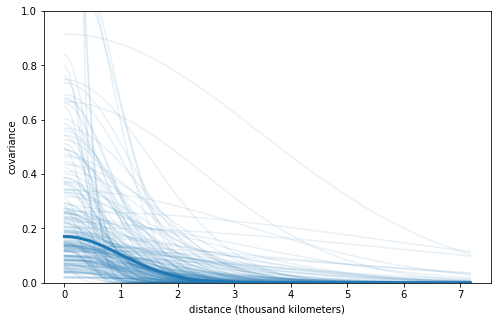

In [62]:
# plot some samples from posterior distribution
trace_n = trace_islands['n']
trace_l = trace_islands['l']

_, ax = plt.subplots(1, 1, figsize = (8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_n) * 
       np.exp(-np.median(trace_l) * xrange**2), lw = 3)

ax.plot(xrange, (trace_n[::20][:, None] * np.exp(- trace_l[::20][:, None] *
                                                xrange ** 2)).T,
       'C0', alpha = .1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')

In [63]:
# potentially compare it to 
# m_10_10 in
# https:/​/​github.​com/​pymc-​devs/​resources

In [65]:
# compute posterior median cov. amoung societies
Σ = np.median(trace_n) * (np.exp(-np.median(trace_l) * islands_dist_sqr))

# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ) ** -0.5)
ρ = Σ_post @ Σ @ Σ_post # @ is matrix multiplication?
ρ = pd.DataFrame(ρ, index = islands_dist.columns,
                columns = islands_dist.columns)
ρ.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.89,0.82,0.00,0.47,0.13,0.01,0.02,0.18,0.0
Ti,0.89,1.00,0.95,0.00,0.47,0.13,0.02,0.03,0.15,0.0
SC,0.82,0.95,1.00,0.00,0.30,0.23,0.04,0.06,0.07,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.05,0.30,0.27,0.00,0.0
Fi,0.47,0.47,0.30,0.00,1.00,0.01,0.00,0.00,0.75,0.0
Tr,0.13,0.13,0.23,0.05,0.01,1.00,0.20,0.70,0.00,0.0
Ch,0.01,0.02,0.04,0.30,0.00,0.20,1.00,0.48,0.00,0.0
Mn,0.02,0.03,0.06,0.27,0.00,0.70,0.48,1.00,0.00,0.0
To,0.18,0.15,0.07,0.00,0.75,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


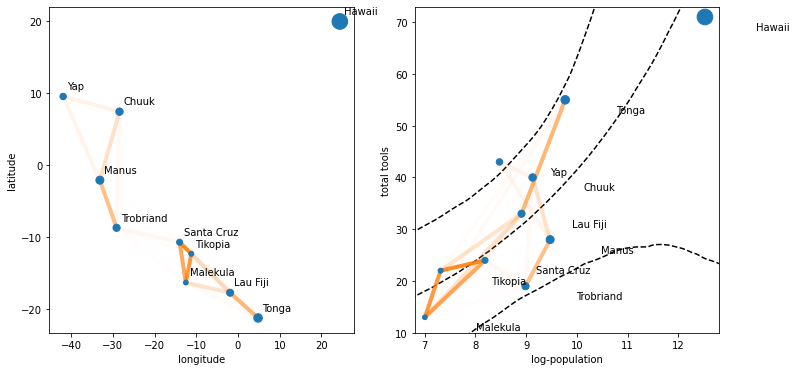

In [67]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max() #what!!
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(trace_islands['α'][:, None] + 
                    trace_islands['β'][:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder = 3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder = 3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+1, islands.total_tools[i]-2.5, itext)
    
ax[1].plot(log_pop_seq, np.median(lambda_post, axis = 0), 'k--')
az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs = {'alpha': 0},
           plot_kwargs = {'color': 'k', 'ls': '--', 'alpha': 1})

for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                  (islands.lat[i], islands.lat[j]), 'C1-',
                  alpha = ρ.iloc[i, j]**2, lw = 4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                  (islands.total_tools[i], islands.total_tools[j]),
                  'C1-', alpha = ρ.iloc[i, j]**2, lw = 4)

ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')

ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.plot();

# Gaussian process classification

In [68]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [72]:
# some preprocessing
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [73]:
with pm.Model() as model_iris:
    l = pm.Gamma('l', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(cov_func = cov)
    f = gp.prior("f", X = X_1)
    
    #logistic inverse link function and bernoulli likelihood
    y_ = pm.Bernoulli("y", p = pm.math.sigmoid(f), observed = y)
    trace_iris = pm.sample(1000, chains = 1, 
                           compute_convergence_checks = False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 45 seconds.


In [76]:
# posterior samples over range of values
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]

# crazy "LinAlgError: Matrix is not positive definite" error
with model_iris:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_iris,
                                                 var_names = ['f_pred'],
                                                 samples = 1000)

LinAlgError: Matrix is not positive definite